In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import math

Start import
Working on midway2-0416.rcc.local with the following versions 
and installation paths:
strax
	v0.15.2	/dali/lgrandi/strax/strax/strax
straxen
	v0.18.4	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [ ]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_radon',
                       available=('events','peak_basics'))

In [18]:
dsets

,name,number,mode,end,start,tags,livetime,raw_records_available,peak_basics_available,event_info_available,events_available
5,019781,19781,tpc_radon,2021-05-19 13:04:27.041,2021-05-19 12:34:24.438,,0 days 00:30:02.603000,False,True,False,True
6,019780,19780,tpc_radon,2021-05-19 12:33:39.996,2021-05-19 12:03:36.560,,0 days 00:30:03.436000,False,True,False,True
10,019776,19776,tpc_radon,2021-05-19 11:32:25.873,2021-05-19 11:02:22.618,flash,0 days 00:30:03.255000,False,True,False,True
17,019769,19769,tpc_radon,2021-05-19 10:05:13.901,2021-05-19 09:55:00.567,,0 days 00:10:13.334000,False,True,False,True
20,019766,19766,tpc_radon,2021-05-19 09:45:11.560,2021-05-19 09:39:24.802,ramp up,0 days 00:05:46.758000,False,True,False,True
21,019765,19765,tpc_radon,2021-05-19 09:38:33.792,2021-05-19 09:31:54.764,ramp up,0 days 00:06:39.028000,False,True,False,True
22,019764,19764,tpc_radon,2021-05-19 09:31:24.919,2021-05-19 09:25:42.744,ramp up,0 days 00:05:42.175000,False,True,False,True
23,019763,19763,tpc_radon,2021-05-19 09:24:37.614,2021-05-19 09:15:03.947,ramp up,0 days 00:09:33.667000,False,True,False,True
24,019762,19762,tpc_radon,2021-05-19 09:14:09.440,2021-05-19 09:03:53.786,ramp up,0 days 00:10:15.654000,False,True,False,True
25,019761,19761,tpc_radon,2021-05-19 09:03:02.769,2021-05-19 08:54:36.743,ramp up,0 days 00:08:26.026000,False,True,False,True


In [3]:
def diffusion_analysis(run_, area_cut=(1e4,5e6), fit_range=(1,1500), plot = False ):
    run = int(run_)
    events = st.get_df(run_,'event_info',progress_bar=False)
    if(plot): ddu.plot_area_width_aft_bkg(events, run_)
    mask_awt = ddu.mask_s2_area_width_aft_bkg(events,run_,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77),high=7,plot=plot)
    e1 = events[mask_awt]
    vd, vd_err, cathodedt, gatedt, s2shift = ddu.drift_velocity_bkg(e1, run_, low=100, plot=plot)
    d, d_err, par = ddu.diffusion_constant_bkg(e1,run_,fit_range=(1,1500),vd = vd,plot=plot)
    return run, vd, vd_err, d, d_err, cathodedt, gatedt, s2shift, par

Drift velocity = 0.663~mm/$\mu$s
Diffusion constant = 48.32 +/- 0.22 cm$^2$/s 


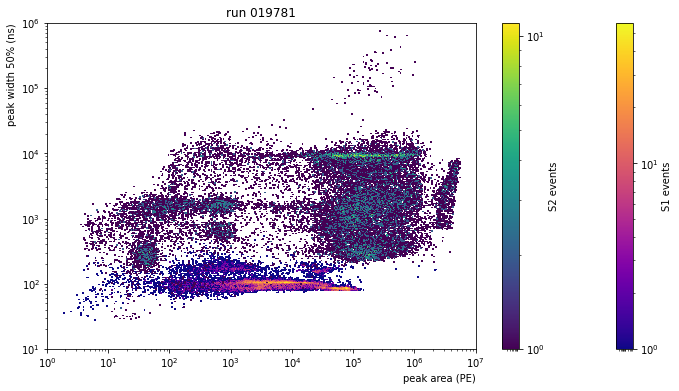

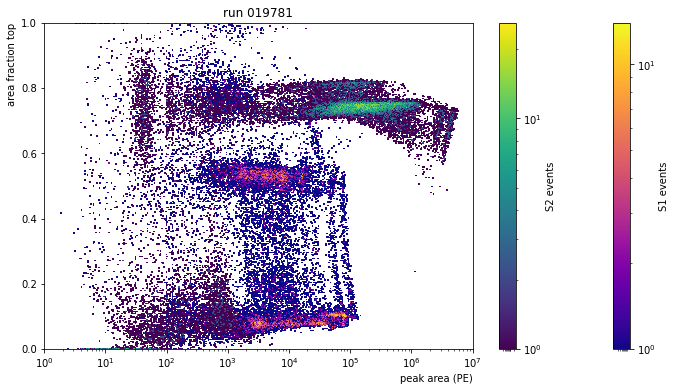

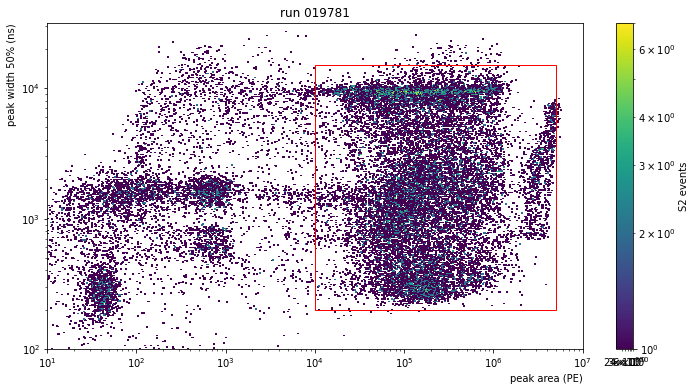

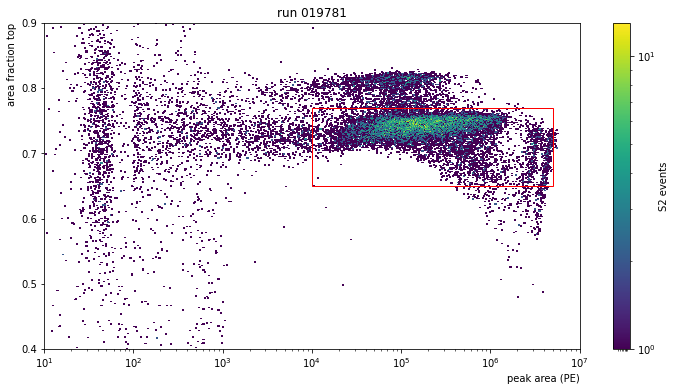

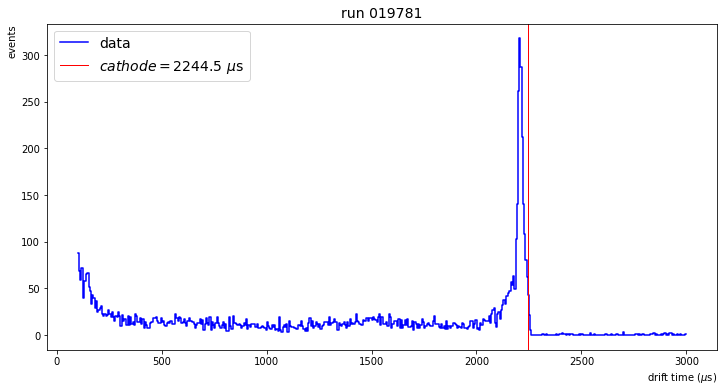

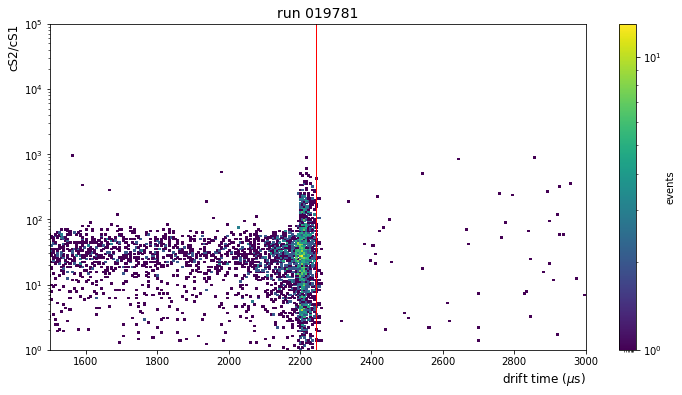

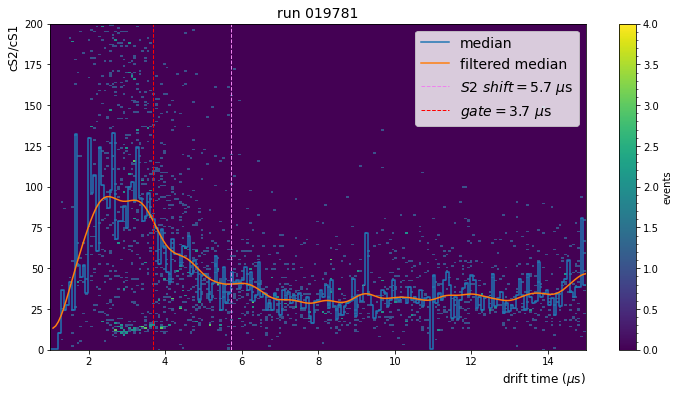

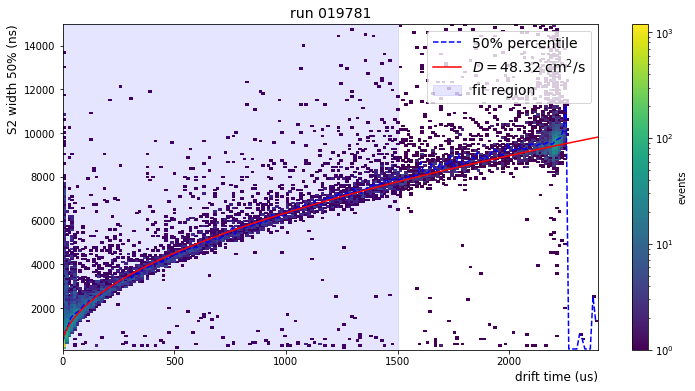

In [4]:
run, vd, vd_err, d, d_err, cathodedt, gatedt, s2shift, par = diffusion_analysis('019781',area_cut=(1e4,5e6),fit_range=(1,1500), plot = True)

In [5]:
def diffusion_analysis_kr(run_kr, area_cut=(5e3,1.1e4), fit_range=(1,1500), plot = False ):
    run = int(run_kr)
    events = st.get_df(run_kr,'event_info_double',progress_bar=False)
    if(plot): ddu.plot_area_width_aft_kr(events, run_kr)
    mask_singleS1 = ddu.mask_KrSingleS1(events)
    if(plot): ddu.plot_area_width_aft_kr(events[mask_singleS1], run_kr)
    e1 = events[mask_singleS1]
    mask_awt = ddu.mask_s2_area_width_aft_kr(e1,run_kr,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77),plot=plot)
    e2 = events[mask_singleS1 & mask_awt]
    vd, vd_err, cathodedt, gatedt, s2shift = ddu.drift_velocity_kr(e1, run_kr, plot=plot)
    d, d_err, par = ddu.diffusion_constant_kr(e2,run_kr,fit_range=(1,1500),vd = vd,plot=plot)
    return run, vd, vd_err, d, d_err, cathodedt, gatedt, s2shift, par

In [6]:
runk, vdk, vd_errk, dk, d_errk, cathodedtk, gatedtk, s2shiftk, park = diffusion_analysis_kr('018871',area_cut=(4e3,1.2e4),fit_range=(1,1500))

In [53]:
def compare_diffusion(run_id, vd, par, run_2, vd_2, par_2, t1 = 'Rn-220', t2 = 'Kr-83m'):
    events = st.get_df(run_id,'event_info',progress_bar=False)
    # s2_width_50 vs drift_time
    t = np.linspace(0, 2400, 200)
    ph = Histdd(events['drift_time']/1e3, events['s2_range_50p_area'],
                bins=(t, np.linspace(100, 15e3, 200)))
    perc50 = np.array(ph.percentile(percentile=50, axis=1))
    
    vd = vd * units.mm / units.us
    vd_2 = vd_2 * units.mm / units.us
    ys_1 = ddu.diffusion_model(t, par[0], vd, par[1])
    ys_2 = ddu.diffusion_model(t, par_2[0], vd_2, par_2[1])
    
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run{run_id} ({t1}) - run{run_2} ({t2})',fontsize=14)
    plt.plot(t, ys_1, label=f'{t1}: $D = {par[0]/1e3/(units.cm**2 / units.s):.2f}$ cm$^2$/s',color='r')
    plt.plot(t, ys_2, label=f'{t2}: $D = {par_2[0]/1e3/(units.cm**2 / units.s):.2f}$ cm$^2$/s',color='b')
    plt.legend(fontsize=14)

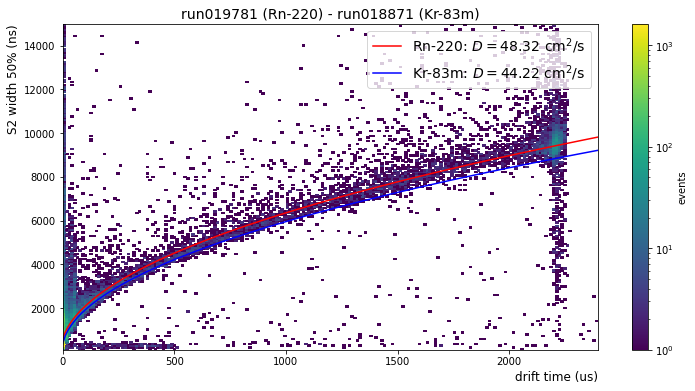

In [54]:
compare_diffusion('019781',vd,par,'018871',vdk,park)